In [1]:
import sys
sys.path.insert(0, '/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages')
import disentangler as dt
from disentangler.dependencies import *
import disentangler.frankencell.config as dtconfig
import seaborn as sns

## Write data subsets

In [5]:
rna_data = dt.bonemarrow.utils.load_GEX_data()

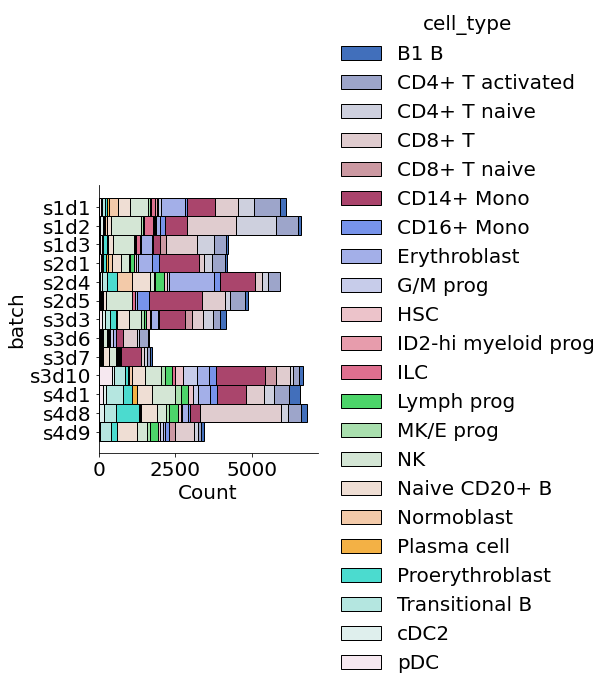

In [6]:
sns.displot(
    data = rna_data.obs,
    y = 'batch',
    hue = 'cell_type',
    multiple = 'stack',
    palette=list(dt.bonemarrow.colors.CELL_PALETTE.values()),
    hue_order=list(dt.bonemarrow.colors.CELL_PALETTE.keys()),
)

In [7]:
!mkdir -p $dtconfig.DATA_DIR

In [8]:
rna_data[rna_data.obs.batch == 's3d10'].write_h5ad(dt.frankencell.config.DATASET_1)
rna_data[rna_data.obs.batch == 's4d1'].write_h5ad(dt.frankencell.config.DATASET_1)

In [9]:
del rna_data

## Generate test

In [ ]:
!./dt-cmd frankencell-gen-test \
    ../BatcheffectFrankencell/data/datasets/s3d10_gex.h5ad \
    ../BatcheffectFrankencell/data/datasets/s4d1_gex.h5ad \
    $dtconfig.DATA_DIR/'test0.h5' \
    -k 0.05 \
    -s 0 -NK 0. -B 0. \
    -t 5

In [2]:
!./dt-cmd frankencell-mira-notune \
    $dtconfig.DATA_DIR/'test0.h5' \
    $dtconfig.DATA_DIR/'test0_result.h5' \
    $dtconfig.DATA_DIR/'test0_plots.png'\
    $dtconfig.DATA_DIR/'test0_dimred.tsv' \

INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/liulab/alynch/projects/multiomics/DisentanglerReproduction/lib/frankencell-python/frankencell/utils.py:61: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  X = dataset['expression'].values if not dataset['expression'] is None else counts
INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: highly_variable
Gathering dataset statistics:   0%|          | 0/4000 [00:00<?, ?it/s]
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/topic_model/base.py:690: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn('Cuda unavailable. Will not use GPU speedup while training.')
Epoch 0:   0%|          | 0/24 [00:00<?, ?it/s]
INFO:mira.topic_model.base:Moving model to device: 

In [2]:
from scipy import sparse
import scanpy as sc
import frankencell

def read_and_process(dynframe):
    
    testdata = frankencell.utils.read_dynframe(dynframe)
    
    sc.pp.filter_genes(testdata, min_cells = 15)
    testdata.raw = testdata

    sc.pp.normalize_total(testdata, target_sum=1e4)
    sc.pp.log1p(testdata)
    sc.pp.highly_variable_genes(testdata)

    testdata.layers['counts'] = testdata.raw.to_adata().X.copy()

    sc.pp.highly_variable_genes(testdata, min_disp=0.5)

    return testdata

data = read_and_process('data/frankencell/test0.h5')

/liulab/alynch/projects/multiomics/DisentanglerReproduction/lib/frankencell-python/frankencell/utils.py:61: FutureWarning:

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.



In [3]:
data.layers['sparse_counts'] = sparse.csr_matrix(data.layers['counts'])

In [6]:
from scib import utils 
from scanpy.external.pp import mnn_correct

In [14]:
data.obs.batch = data.obs.batch.astype('category')

In [16]:
batches = utils.split_batches(data, batch='batch')

In [17]:
mnn_correct(*batches)

/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/mnnpy/utils.py:14: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: No implementation of function Function(<function norm at 0x2aaab6feef80>) found for signature:
 
 >>> norm(x=array(float32, 2d, A), axis=Literal[int](1))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'norm_impl': File: numba/np/linalg.py: Line 2351.
    With argument(s): '(x=array(float32, 2d, A), axis=int64)':
   Rejected as the implementation raised a specific error:
     TypingError: missing a required argument: 'a'
  raised from /liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/numba/core/typing/templates.py:791

During: resolving callee type: Function(<function norm at 0x2aaab6feef80>)
During: typing of call at /liulab/alynch/projects/benchmarking_python/lib/python3.7/site-pack

Performing cosine normalization...


/liulab/alynch/projects/cuda/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__

/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/mnnpy/utils.py:14: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: No implementation of function Function(<function norm at 0x2aaab6feef80>) found for signature:
 
 >>> norm(x=array(float32, 2d, A), axis=Literal[int](1))
 
There are 2 candidate implementations:
    - Of which 2 did not match due to:
    Overload in function 'norm_impl': File: numba/np/linalg.py: Line 2351.
      With argument(s): '(x=array(float32, 2d, A), axis=int64)':
     Rejected as the implementation raised a specific error:
       TypingError: missing a required argument: 'a'
  raised from /liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/numba/core/typi

Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...


/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/mnnpy/mnn.py:179: DeprecationWarning:

The n_jobs argument has been renamed "workers". The old name "n_jobs" will stop working in SciPy 1.8.0.

/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/mnnpy/utils.py:88: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "find_mutual_nn" failed type inference due to: non-precise type pyobject
During: typing of argument at /liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/mnnpy/utils.py (94)

File "../../benchmarking_python/lib/python3.7/site-packages/mnnpy/utils.py", line 94:
def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    <source elided>
    mutual_2 = []
    for index_2 in range(data2.shape[0]):
    ^


/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/numba/core/object_mode_passes.py:152: NumbaWarning:

Function "find_mutual_nn" was compiled in ob

  Computing correction vectors...


/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/mnnpy/utils.py:102: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "compute_correction" failed type inference due to: non-precise type pyobject
During: typing of argument at /liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/mnnpy/utils.py (107)

File "../../benchmarking_python/lib/python3.7/site-packages/mnnpy/utils.py", line 107:
def compute_correction(data1, data2, mnn1, mnn2, data2_or_raw2, sigma):
    <source elided>
    vect_reduced = np.zeros((data2.shape[0], vect.shape[1]), dtype=np.float32)
    for index, ve in zip(mnn2, vect):
    ^


/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/numba/core/object_mode_passes.py:152: NumbaWarning:

Function "compute_correction" was compiled in object mode without forceobj=True.

File "../../benchmarking_python/lib/python3.7/site-packages/mnnpy/utils.py", line 107:
def c

IndexError: arrays used as indices must be of integer (or boolean) type

In [4]:
model = mira.topics.TopicModel(
    *data.shape,
    cost_beta = 2.,
    feature_type='expression',
    exogenous_key='highly_variable',
    categorical_covariates=['batch'],
    counts_layer = 'sparse_counts',
    min_learning_rate = 3e-3,
    max_learning_rate = 0.25
)

t = mira.topics.Tracker()
model.set_params(num_topics = 6, seed = 2556 + 22, decoder_dropout = 0.05)\
    .fit(data, writer = t)

[(0.0, 1.0)]

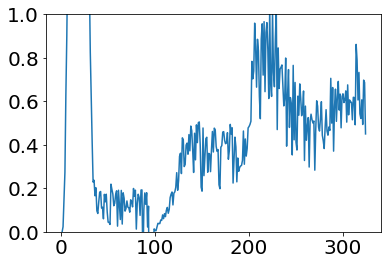

In [9]:
ax = sns.lineplot(
    y = t['average_MI'],
    x = range(len(t['average_MI']))
)

ax.set(ylim = (0,1))

dimred = pd.read_csv('data/frankencell/test0_dimred.tsv', sep= '\t')\
    .set_index('cell_id')

data.obsm['X_umap_features'] = model.best_estimator_.predict(data)

import harmonypy as hm
sc.tl.pca(data)

ho = hm.run_harmony(
    data.obsm['X_pca'][:,:10], 
    data.obs, 
    ['batch'],
    max_iter_harmony=20
)

data.obsm['X_umap_features'] = ho.Z_corr.T

In [7]:
model.predict(data)
model.get_umap_features(data, box_cox=0.25)

Predicting latent vars:   0%|          | 0/16 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


... storing 'edge' as categorical
... storing 'batch' as categorical
... storing 'feature_type' as categorical


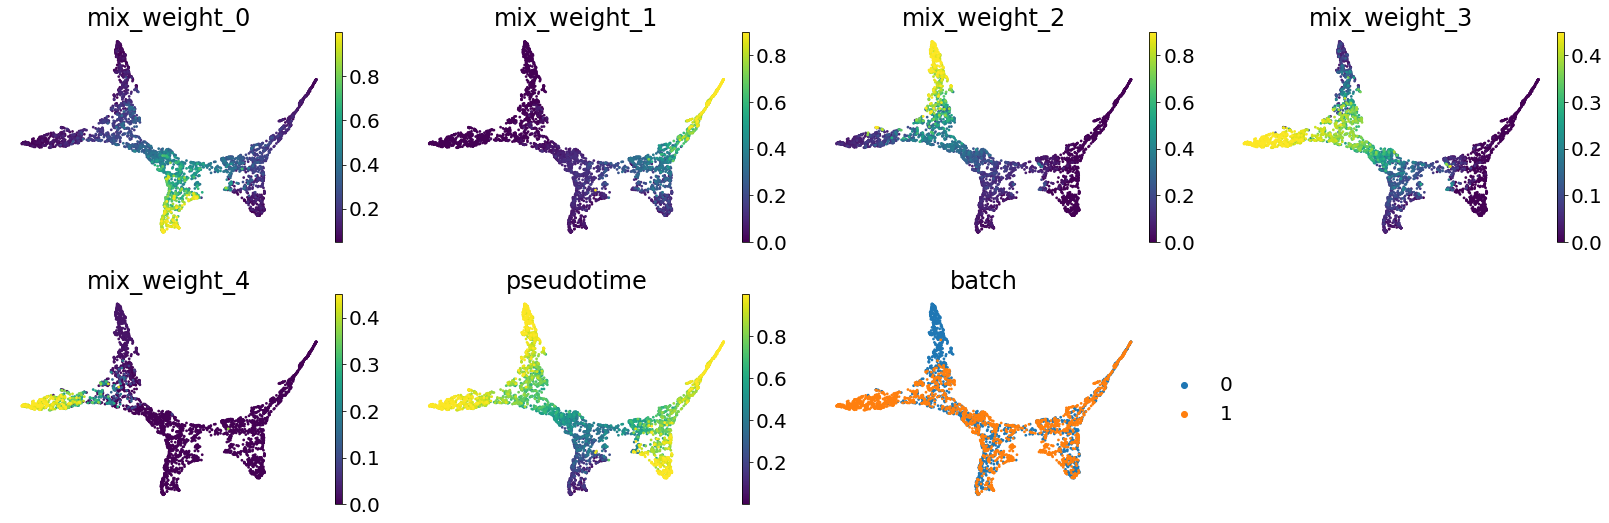

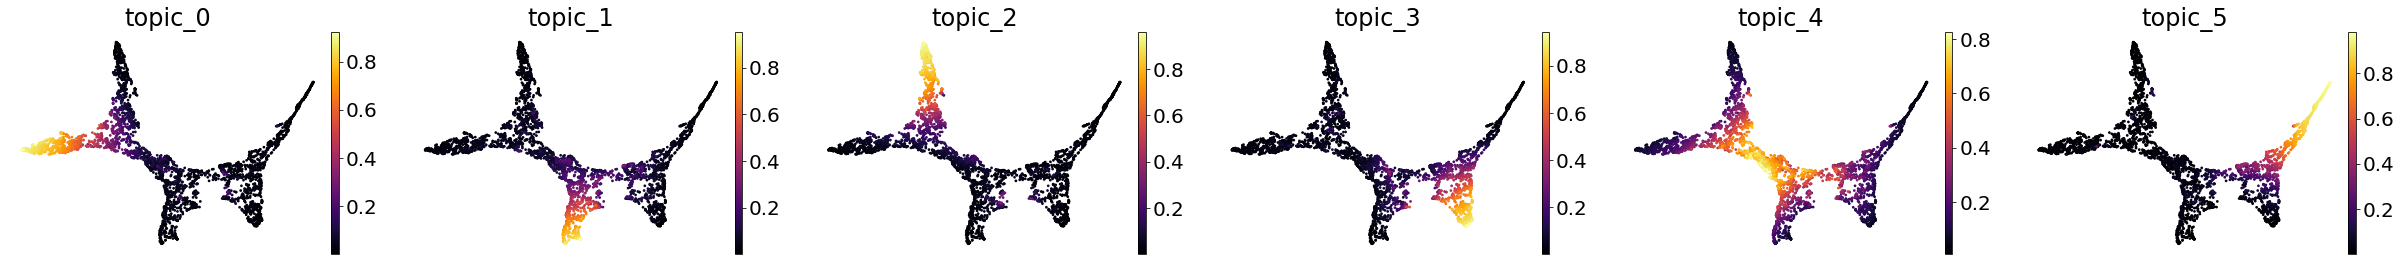

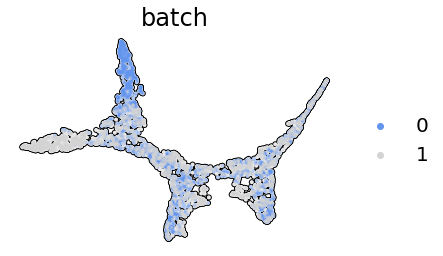

In [8]:
sc.pp.neighbors(data, use_rep='X_umap_features', metric='euclidean')
sc.tl.umap(data, min_dist=0.1)

sc.pl.umap(data, color = ['mix_weight_' + str(i) for i in range(5)] + ['pseudotime', 'batch'],
          frameon=False)

sc.pl.umap(data, color = model.topic_cols, **mira.pref.topic_umap())

sc.pl.umap(data, color = 'batch', palette = ['cornflowerblue','lightgrey'], s= 50, alpha = 0.5,
          add_outline=True, frameon=False)

In [3]:
!./lib/frankencell-python/cmd-frankencell eval mira \
    -t $dtconfig.DATA_DIR/'test0_result.h5' \
    -o $dtconfig.DATA_DIR/'test0_eval.h5' \
    -r $dtconfig.DATA_DIR/'test0_eval.tsv' \
    -p "threshold=1." \

Executing 'mira' on '20220917_215342__data_wrapper__sR20C81nOu'
With parameters: list(threshold = 1, n_neighbors = 30L, metric = "manhattan",     box_cox = 0.5, ka = 5L)
inputs: counts
priors : start_id, end_id, dimred
Input saved to /tmp/RtmpkohoII/file58cb741171477/ti
Running ./run --dataset input.h5 --output output.h5
INFO:root:Added key to obsm: X_diffmap, normalized diffmap with 8 components.
INFO:root:Added key to uns: eigen_gap
INFO:mira.pseudotime.pseudotime:Found 1 components of KNN graph.
INFO:mira.adata_interface.core:Added cols to obs: mira_connected_components
INFO:mira.pseudotime.pseudotime:Calculating inter-cell distances ...
INFO:root:Using 1 core. Speed this up by allocating more n_jobs.
Recommending 5 diffusion map components.
lating pseudotime: 2164it [00:00, 247835.35it/s]                   
INFO:mira.pseudotime.pseudotime:Calculating transport map ...
INFO:mira.adata_interface.pseudotime:Added key to obs: mira_pseudotime
INFO:mira.adata_interface.pseudotime:Added k

In [10]:
!cat $dtconfig.DATA_DIR/'test0_eval.tsv'

time_waypointedgeodesic	11.285210609436
correlation	0.801178497285648
time_correlation	0.683016777038574
edge_flip	0.8
time_edge_flip	0.0624165534973145
time_mapping_branches	1.88043665885925
recovery_branches	0.528947312937657
relevance_branches	0.620885052734099
F1_branches	0.571240626184652


In [24]:
scib.__file__

'/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/scib/__init__.py'

In [35]:
!snakemake -s disentangler/frankencell/pipeline.smk --use-conda --use-envmodules --cores 5 -P evaluate_bio_metrics -p\
    data/frankencell/results_summary/bio_mira/0.5-0.5-0.0-2556.tsv data/frankencell/results_summary/batch_mira/0.5-0.5-0.0-2556.tsv

Building DAG of jobs...
Using shell: /usr/bin/bash
Provided cores: 5
Rules claiming more threads will be scaled down.
Job stats:
job                       count    min threads    max threads
----------------------  -------  -------------  -------------
evaluate_batch_metrics        1              1              1
evaluate_bio_metrics          1              1              1
get_dimred                    1              1              1
total                         3              1              1

Select jobs to execute...

[Sat Sep  3 17:05:43 2022]
rule get_dimred:
    input: data/frankencell/test/0.5-0.5-0.0-2556.h5
    output: data/frankencell/process/mira/0.5-0.5-0.0-2556.h5, data/frankencell/plots/mira/0.5-0.5-0.0-2556.png, data/frankencell/dimred/mira/0.5-0.5-0.0-2556.tsv
    jobid: 1
    wildcards: method=mira, NK=0.5, B=0.5, K=0.0, seed=2556
    priority: highest
    resources: tmpdir=/tmp

./dt-cmd frankencell-mira data/frankencell/test/0.5-0.5-0.0-2556.h5 data/frankencell/pro

## Intro figures

In [2]:
import frankencell

In [3]:
from scipy import sparse

In [171]:
#testdata = frankencell.utils.read_dynframe('data/frankencell/test/0.05555555555555555-0.0-0.0-104.h5')
testdata = frankencell.utils.read_dynframe('data/frankencell/test/0.0-0.0-0.0-24.h5')

/liulab/alynch/projects/multiomics/DisentanglerReproduction/lib/frankencell-python/frankencell/utils.py:61: FutureWarning:

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.



In [172]:
sc.pp.filter_genes(testdata, min_cells = 15)
testdata.raw = testdata

sc.pp.normalize_total(testdata, target_sum=1e4)
sc.pp.log1p(testdata)
sc.pp.highly_variable_genes(testdata)

testdata.layers['counts'] = testdata.raw.to_adata().X.copy()

sc.pp.highly_variable_genes(testdata, min_disp=0.5)

In [173]:
data = testdata

In [203]:
data.layers['sparse_counts'] = sparse.csr_matrix(data.layers['counts'])

model = mira.topics.TopicModel(
    *data.shape,
    feature_type='expression',
    exogenous_key='highly_variable',
    counts_layer='sparse_counts',
    categorical_covariates='batch',
    cost_beta = 2.
)

model.set_learning_rates(3e-3, 0.25)

model.set_params(num_topics = 6, decoder_dropout = 0.05, 
             seed = 2556 + 22)

#model.set_params(num_topics = 5,
#                 covariates_dropout = 0.,
#                 mask_dropout = 0., dependence_beta = 0.)
model.fit(data)

model.predict(data)
model.get_umap_features(data, box_cox=0.33)

sc.pp.neighbors(data, use_rep='X_umap_features', metric='manhattan')
sc.tl.umap(data, min_dist=0.1)

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: highly_variable


Gathering dataset statistics:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/24 [00:00<?, ?it/s]

INFO:mira.topic_model.base:Moving model to device: cpu


Predicting latent vars:   0%|          | 0/16 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning:

Trying to modify attribute `._uns` of view, initializing view as actual.



<AxesSubplot:title={'center':'edge'}, xlabel='UMAP1', ylabel='UMAP2'>

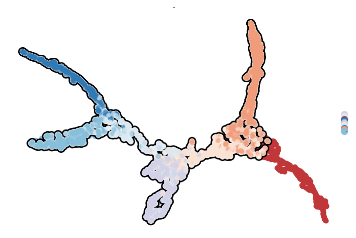

In [204]:
ax = sc.pl.umap(data[data.obs.batch == '0'], color = 'edge', frameon=False,
           na_color='lightgrey', show=False,
          palette= {
              '1' : sns.color_palette('Purples')[1], 
              '2' : sns.color_palette('RdBu')[2], 
              '3' : sns.color_palette('RdBu')[-3],
              'B cell' : sns.color_palette('RdBu')[0],
              'Mono' : sns.color_palette('RdBu')[-1],
              'pDC' : sns.color_palette('RdBu')[-2],
              'NK' : sns.color_palette('RdBu')[1], 
                   },
           size=100,
           add_outline=False,
            )

sc.pl.umap(data[data.obs.batch == '1'], color = 'edge', frameon=False, ax = ax,
           na_color='lightgrey', show=False,
          palette= {
              '1' : sns.color_palette('Purples')[1], 
              '2' : sns.color_palette('RdBu')[2], 
              '3' : sns.color_palette('RdBu')[-3],
              'B cell' : sns.color_palette('RdBu')[0],
              'Mono' : sns.color_palette('RdBu')[-1],
              'pDC' : sns.color_palette('RdBu')[-2],
              'NK' : sns.color_palette('RdBu')[1], 
                   },
           size=100,
           add_outline=True,
            )
#sc.pl.umap(data, color = 'batch', frameon=False)

In [205]:
model.impute(data)
model.get_batch_effect(data)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Imputing features:   0%|          | 0/16 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: imputed
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Imputing features:   0%|          | 0/16 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: batch_effect


In [206]:
from disentangler.plots import disentanglement_plot

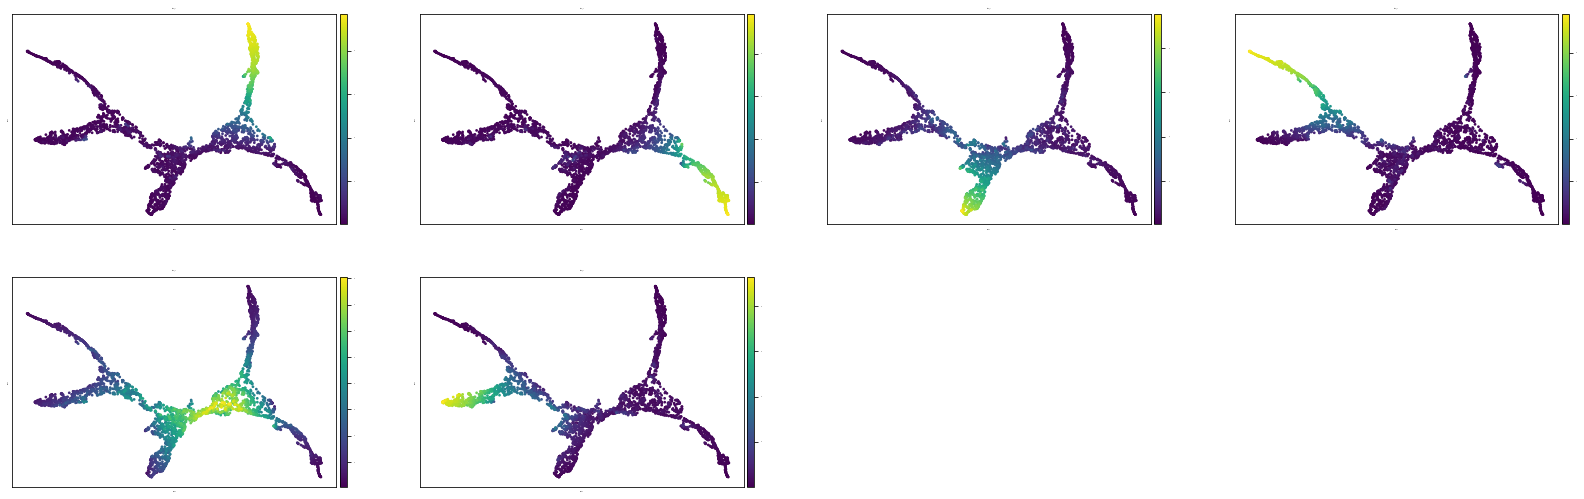

In [207]:
sc.pl.umap(data, color = model.topic_cols)

In [208]:
model.get_top_genes(3, 32)

array(['NEAT1', 'FTL', 'MTSS1', 'IGIP', 'SIPA1L1', 'DOCK4', 'CTSS',
       'SEMA3A', 'LINC00968', 'GPR155', 'G0S2', 'SLC49A4', 'CERT1',
       'PNPT1', 'CD101', 'YPEL2', 'TNFSF10', 'FAM49A', 'PLEKHO2', 'VMP1',
       'NRG1', 'VNN2', 'HEATR6', 'AQP9', 'MXI1', 'SAMSN1', 'CMTM6',
       'SNX24', 'TGS1', 'DPEP2', 'IL15', 'G6PD'], dtype=object)

In [209]:
import matplotlib
matplotlib.rc('font' , size = 1)

In [210]:
subdata = data[data.obs.edge.isin(['NK','B cell','2'])]
subdata.layers['imputed'] = subdata.layers['imputed'] + 0.0001

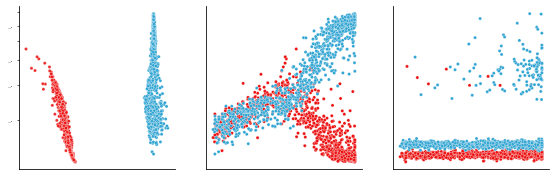

In [211]:
g = 'CD3G'
fig, ax = plt.subplots(1,3,figsize=(9.5,3))

pal = ['#ed1212e0', '#34a6d3ff']
def transform_zeros(x, batch):
    return np.where(np.isclose(x, 0.), x + batch, x) + np.random.randn(len(x)) * 0.05

sns.scatterplot(
    ax = ax[2],
    s = 10,
    x = subdata.obs.pseudotime,
    alpha = 1,
    y = transform_zeros(
        subdata.obs_vector(g, layer = None),
        subdata.obs_vector('batch').astype(int) * 0.25,
    ),
    hue = subdata.obs.batch,
    legend=False,    
    palette=pal,
)
ax[2].set(xlabel = None, ylabel = None,
          xticks = [], yticks = [])

_ax = disentanglement_plot(subdata, ax[0], g, color = 'batch', size = 10,
                    palette= pal[::-1],
                    )
sns.despine()
_ax.set(xlabel = None, ylabel = None)
_ax.set(yticks = [], xticks = [])

sns.scatterplot(
    ax = ax[1],
    s = 10,
    x = subdata.obs.pseudotime,
    alpha = 1.,
    y  = np.log(subdata.obs_vector(g, layer = 'imputed')),
    hue = subdata.obs.batch,
    legend=False,    
    palette= pal,
)
ax[1].set(xlabel = None, ylabel = None,
          xticks = [], yticks = [])
#plt.tight_layout()
plt.savefig('figure0/disentangled_geneplot2.png', bbox_inches = 'tight',
           dpi = 300)

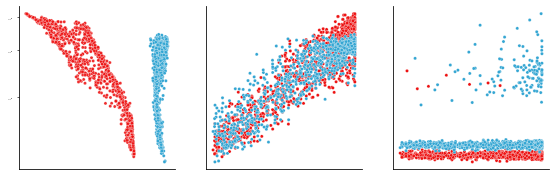

In [194]:
g = 'CD3G'
fig, ax = plt.subplots(1,3,figsize=(9.5,3))

pal = ['#ed1212e0', '#34a6d3ff']
def transform_zeros(x, batch):
    return np.where(np.isclose(x, 0.), x + batch, x) + np.random.randn(len(x)) * 0.05

sns.scatterplot(
    ax = ax[2],
    s = 10,
    x = subdata.obs.pseudotime,
    alpha = 1,
    y = transform_zeros(
        subdata.obs_vector(g, layer = None),
        subdata.obs_vector('batch').astype(int) * 0.25,
    ),
    hue = subdata.obs.batch,
    legend=False,    
    palette=pal,
)
ax[2].set(xlabel = None, ylabel = None,
          xticks = [], yticks = [])

_ax = disentanglement_plot(subdata, ax[0], g, color = 'batch', size = 10,
                    palette= pal[::-1],
                    )
sns.despine()
_ax.set(xlabel = None, ylabel = None)
_ax.set(yticks = [], xticks = [])

sns.scatterplot(
    ax = ax[1],
    s = 10,
    x = subdata.obs.pseudotime,
    alpha = 1.,
    y  = np.log(subdata.obs_vector(g, layer = 'imputed')),
    hue = subdata.obs.batch,
    legend=False,    
    palette= pal,
)
ax[1].set(xlabel = None, ylabel = None,
          xticks = [], yticks = [])
#plt.tight_layout()
plt.savefig('figure0/confounded_geneplot2.png', bbox_inches = 'tight',
           dpi = 300)